<a href="https://colab.research.google.com/github/anuytok/WES/blob/main/WES_%D0%95%D1%84%D0%B8%D0%BC%D0%BE%D0%B2%D0%B0_%D0%90%D0%BD%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем необходимые файлы

In [ ]:
!wget https://makarich.fbb.msu.ru/enabieva/ngs2022/GRCh38_full_analysis_set_plus_decoy_hla.dict

In [ ]:
!wget https://makarich.fbb.msu.ru/enabieva/ngs2022/GRCh38_full_analysis_set_plus_decoy_hla.fa.fai

In [ ]:
!wget https://makarich.fbb.msu.ru/enabieva/ngs2022/GRCh38_full_analysis_set_plus_decoy_hla.fa.gz

In [ ]:
!gunzip /content/GRCh38_full_analysis_set_plus_decoy_hla.fa.gz

In [ ]:
!wget https://makarich.fbb.msu.ru/enabieva/ngs2022/chd_child.bam

In [ ]:
!wget https://makarich.fbb.msu.ru/enabieva/ngs2022/chd_child.bam.bai

Скачиваем GATK

In [ ]:
!wget https://github.com/broadinstitute/gatk/releases/download/4.3.0.0/gatk-4.3.0.0.zip

In [ ]:
!unzip gatk-4.3.0.0.zip

Запустим HaplotypeCaller для одного образца 

In [ ]:
 !/content/gatk-4.3.0.0/gatk --java-options "-Xmx4g" HaplotypeCaller  \
   -R GRCh38_full_analysis_set_plus_decoy_hla.fa \
   -I chd_child.bam \
   -O chd_child.vcf.gz

In [ ]:
!gunzip chd_child.vcf.gz

Найдем кодирующие и некодирующие варианты. Для этого воспользуемся программой snpEff, с помощью которой сначала проаннотируем их

In [ ]:
!wget https://snpeff.blob.core.windows.net/versions/snpEff_latest_core.zip 
!unzip snpEff_latest_core.zip

Выберем аннотацию

In [ ]:
!java -jar /content/snpEff/snpEff.jar databases | grep GRCh38

GRCh38.105                                                  	Homo_sapiens                                                	          	                              	[https://snpeff.blob.core.windows.net/databases/v5_1/snpEff_v5_1_GRCh38.105.zip, https://snpeff.blob.core.windows.net/databases/v5_0/snpEff_v5_0_GRCh38.105.zip]
GRCh38.86                                                   	GRCh38.86                                                   	          	                              	[https://snpeff.blob.core.windows.net/databases/v5_1/snpEff_v5_1_GRCh38.86.zip, https://snpeff.blob.core.windows.net/databases/v5_0/snpEff_v5_0_GRCh38.86.zip]
GRCh38.99                                                   	Homo_sapiens                                                	          	                              	[https://snpeff.blob.core.windows.net/databases/v5_1/snpEff_v5_1_GRCh38.99.zip, https://snpeff.blob.core.windows.net/databases/v5_0/snpEff_v5_0_GRCh38.99.zip]
GRCh38.mane.0.95.ensembl     

Проаннотируем с помощью snpEff

In [ ]:
!java -Xmx8g -jar /content/snpEff/snpEff.jar GRCh38.105 chd_child.vcf > chd_child.ann.vcf

Создадим новый файл, включащий в себя только кодирующие замены. Команда выбирает только строчки, содержащие подстроки ”#” (это заголовок), “synonymous”, “missense”, или “stop_gained”). Это не совсем все кодирующие изменения, но подавляющее большинство.


In [ ]:
!egrep '#|synonymous|missense|stop_gained' chd_child.ann.vcf > chd_child.ann.coding.vcf 

Посмотрим на число синонимичных и несинонимичных замен до фильтрации

In [ ]:
!egrep '#|synonymous' chd_child.ann.coding.vcf | wc -l

14173


In [ ]:
!egrep '#|missense' chd_child.ann.coding.vcf | wc -l

13537


In [ ]:
!egrep '#|stop_gained' chd_child.ann.coding.vcf | wc -l

3489


В идеале, мы должны получить 11-14к синонимичных и 10-12к несинонимичных замен. У нас получилось 14173 синонимичных и 17026 несинонимичных замен.

In [ ]:
! java -jar /content/snpEff/SnpSift.jar tstv chd_child.ann.coding.vcf

ti/tv (отношение транзиций к трансверсиям) в кодирующих участках вышло 3,049. Близко к значению 3, которые является нормальным для кодирующих последовательностей человека


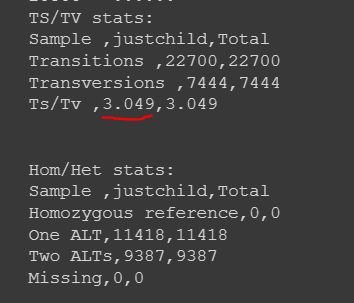

Проведем жесткую фильтрацию полученных вариантов. 

Параметры могут быть разными для однонуклеотидных вариантов (SNPs) и инделов, поэтому разделим их на 2 отдельных файла, проведем для каждого фильтрацию по параметрам, указанным в https://gatk.broadinstitute.org/hc/en-us/articles/360035531112--How-to-Filter-variants-either-with-VQSR-or-by-hard-filtering#2 , а затем объединим полученные файлы и вновь проаннотируем.


SNP

In [ ]:
!/content/gatk-4.3.0.0/gatk SelectVariants \
    -V chd_child.ann.coding.vcf \
    -select-type SNP \
    -O snps.vcf

indels

In [ ]:
!/content/gatk-4.3.0.0/gatk SelectVariants \
    -V chd_child.ann.coding.vcf \
    -select-type INDEL \
    -O indels.vcf

Фильтруем SNP с оптимальными параметрами (были выбраны за счет рекомендаций - https://gatk.broadinstitute.org/hc/en-us/articles/360035890471-Hard-filtering-germline-short-variants и https://gatk.broadinstitute.org/hc/en-us/articles/360037499012-I-am-unable-to-use-VQSR-recalibration-to-filter-variants)

In [ ]:
!/content/gatk-4.3.0.0/gatk --java-options "-Xmx4g" VariantFiltration \
    -V snps.vcf \
    -filter "QD < 2.0" --filter-name "QD2" \
    -filter "QUAL < 30.0" --filter-name "QUAL30" \
    -filter "SOR > 3.0" --filter-name "SOR3" \
    -filter "FS > 60.0" --filter-name "FS60" \
    -filter "MQ < 40.0" --filter-name "MQ40" \
    -filter "MQRankSum < -12.5" --filter-name "MQRankSum-12.5" \
    -filter "ReadPosRankSum < -8.0" --filter-name "ReadPosRankSum-8" \
    -O snps_filtered.vcf

Фильтруем indels с оптимальными параметрами

In [ ]:
!/content/gatk-4.3.0.0/gatk --java-options "-Xmx4g" VariantFiltration \
    -V indels.vcf \
    -filter "QD < 2.0" --filter-name "QD2" \
    -filter "QUAL < 30.0" --filter-name "QUAL30" \
    -filter "FS > 200.0" --filter-name "FS200" \
    -filter "ReadPosRankSum < -20.0" --filter-name "ReadPosRankSum-20" \
    -O indels_filtered.vcf

The InbreedingCoeff statistic is a population-level calculation that is only available with 10 or more samples. If you have fewer samples you will need to omit that particular filter statement.

Объединим полученные файлы

In [ ]:
!/content/gatk-4.3.0.0/gatk MergeVcfs \
  -I snps_filtered.vcf \
  -I indels_filtered.vcf \
  -O filtered.vcf

Вытащим строки, прошедшие фильтрацию

In [ ]:
!egrep 'PASS' filtered.vcf > pass_filtered.vcf

Проаннотируем с помощью snpEff

In [ ]:
!java -Xmx8g -jar /content/snpEff/snpEff.jar GRCh38.105 pass_filtered.vcf > pass_filtered.ann.vcf

Вытащим кодирующие последовательности

In [ ]:
!egrep '#|synonymous|missense|stop_gained' pass_filtered.ann.vcf > pass_filtered.ann.coding.vcf 

Посмотрим на число синонимичных и несинонимичных замен до фильтрации

In [ ]:
!egrep '#|synonymous' pass_filtered.ann.coding.vcf | wc -l

10469


In [ ]:
!egrep '#|missense' pass_filtered.ann.coding.vcf | wc -l

9765


In [ ]:
!egrep '#|stop_gained' pass_filtered.ann.coding.vcf | wc -l

95


В идеале, мы должны получить 11-14к синонимичных и 10-12к несинонимичных замен. Было 14173 синонимичных, после фильтрации стало 10469. Несинонимичных было 17026, после фильтрации стало 9860. Число замен при таких параметрах фильтрации стало меньше, а значит жесткая фильтрация с такими подобранными по рекомендациям параметрам подходит для улучшения полученных результатов по количеству замен. 

По результатам фильтрации видно, что несинонимичных замен стало примерно в 1,7 раза меньше, когда синонимичных стало примерно в 1,35 раз меньше. Таким образом, несинонимичные замены подверглись наиболее жесткой фильтрации. Вероятно это связано с тем, что в результате синонимичных замен не происходит изменения последовательности белка, так как у генетического кода есть свойство вырожденности - когда 1 аминокислота кодируется несколькими триплетами.Несинонимичная замена - это нуклеотидная мутация, которая изменяет аминокислотную последовательность белка. Поскольку несинонимичные замены приводят к биологическим изменениям в организме, они подвержены естественному отбору.



Посмотрим на отношение транзиций к трансверсиям

In [ ]:
! java -jar /content/snpEff/SnpSift.jar tstv pass_filtered.ann.coding.vcf

ti/tv (отношение транзиций к трансверсиям) в кодирующих участках до фильтрации было 3,049, после фильтрации стало 3,068.


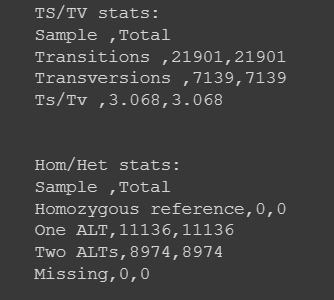

В кодирующих последовательностях человека отношение транзиций к трансверсиям примерно равно 3. После фильтрации значение не сильно изменилось, и все равно близко к 3.

Попробуем отфильтровать с помощью CNNScoreVariants

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda env create -f gatkcondaenv.yml

In [ ]:
!source activate gatk

In [ ]:
! conda install -c bioconda gatktool

In [ ]:
!conda info --envs

# conda environments:
#
                         /path/to/GATK_env
                         /path/to/myGATK_env
base                     /usr/local
gatk                     /usr/local/envs/gatk



In [ ]:
!conda install numpy

In [ ]:
! conda update numpy

In [ ]:
!conda create numpy -n gatk

In [ ]:
!conda update numpy -n gatk

In [ ]:
!/content/gatk-4.3.0.0/gatk CNNScoreVariants \
   -V chd_child.vcf \
   -R GRCh38_full_analysis_set_plus_decoy_hla.fa \
   -O CNN_annotated.vcf

Using GATK jar /content/gatk-4.3.0.0/gatk-package-4.3.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /content/gatk-4.3.0.0/gatk-package-4.3.0.0-local.jar CNNScoreVariants -V chd_child.vcf -R GRCh38_full_analysis_set_plus_decoy_hla.fa -O CNN_annotated.vcf
22:58:43.265 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.3.0.0/gatk-package-4.3.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:58:43.403 INFO  CNNScoreVariants - ------------------------------------------------------------
22:58:43.403 INFO  CNNScoreVariants - The Genome Analysis Toolkit (GATK) v4.3.0.0
22:58:43.403 INFO  CNNScoreVariants - For support and documentation go to https://software.broadinstitute.org/gatk/
22:58:43.403 INFO  CNNScoreVariants - Executing as root@6b23dcd5f47a on Linux v5.10.133+ amd64
22:58:43.404 INFO  CNNScor

Я очень хотела и старалась сделать фильтрацию CNNScoreVariants (часов 5), но у меня так и не получилось связать гугл коллаб с gatk. 

The bioconda environment doesn't actually configure the gatk conda environment (it installs gatk, but not the python dependencies required for CNNScoreVariants). You need to set up the gatk conda environment, as described in the Python Dependencies section in the README.md file: https://github.com/broadinstitute/gatk#readme.

Я сделала абсолютно то же самое, но фильтрация так и не пошла...

Может, за старания получу неполный балл за это задание :с

Напишите, сколько в вашем окончательном списке:
- Protein truncating variants (инделов со сдвигом рамки считывания,
nonsense-вариантов)
- Гомозиготных вариантов, изменяющих последовательность белка. Приведите их список


Protein-truncating variants (PTVs) are genetic variants predicted to shorten the coding sequence of genes, through ways like a stop-gain mutation. PTV is sometime categorized under the umbrella term frameshift or truncating variants (FTVs), which includes both PTVs and DNA variants caused by frameshift mutation.

In [ ]:
!egrep '#|frameshift' pass_filtered.ann.coding.vcf 

##SnpEffVersion="5.1d (build 2022-04-19 15:49), by Pablo Cingolani"
##SnpEffCmd="SnpEff  GRCh38.105 pass_filtered.vcf "
##INFO=<ID=ANN,Number=.,Type=String,Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | Rank | HGVS.c | HGVS.p | cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
##INFO=<ID=LOF,Number=.,Type=String,Description="Predicted loss of function effects for this variant. Format: 'Gene_Name | Gene_ID | Number_of_transcripts_in_gene | Percent_of_transcripts_affected'">
##INFO=<ID=NMD,Number=.,Type=String,Description="Predicted nonsense mediated decay effects for this variant. Format: 'Gene_Name | Gene_ID | Number_of_transcripts_in_gene | Percent_of_transcripts_affected'">
chr3	149520808	.	C	CTTAA	490.6	PASS	AC=1;AF=0.500;AN=2;BaseQRankSum=1.697;DP=21;ExcessHet=0.0000;FS=2.092;MLEAC=1;MLEAF=0.500;MQ=61.02;MQRankSum=1.209;Q

In [ ]:
!egrep '#|frameshift' pass_filtered.ann.coding.vcf | wc -l

10


Protein truncating variants = 10

Гомозиготные варианты (альтернативные) аходятся в 1/1. 

In [ ]:
!egrep '1/1' pass_filtered.ann.coding.vcf > homoz.vcf

In [ ]:
!egrep '1/1' pass_filtered.ann.coding.vcf | wc -l

12755


Гомозиготных альтернативных вариантов 12755. Посмотрим на верхушку таблицы

In [ ]:
!head homoz.vcf

chr1	69511	.	A	G	98.14	PASS	AC=2;AF=1.00;AN=2;DP=5;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=45.98;QD=24.54;SOR=1.609;ANN=G|missense_variant|MODERATE|OR4F5|ENSG00000186092|transcript|ENST00000641515.2|protein_coding|3/3|c.484A>G|p.Thr162Ala|544/2618|484/981|162/326||	GT:AD:DP:GQ:PL	1/1:0,4:4:12:112,12,0
chr1	946247	.	G	A	108.14	PASS	AC=2;AF=1.00;AN=2;DP=4;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=60.00;QD=27.04;SOR=1.609;ANN=A|synonymous_variant|LOW|NOC2L|ENSG00000188976|transcript|ENST00000327044.7|protein_coding|16/19|c.1843C>T|p.Leu615Leu|1859/2757|1843/2250|615/749||,A|upstream_gene_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000496938.1|processed_transcript||n.-685C>T|||||685|,A|downstream_gene_variant|MODIFIER|SAMD11|ENSG00000187634|transcript|ENST00000455979.1|protein_coding||c.*2094G>A|||||1988|WARNING_TRANSCRIPT_NO_START_CODON,A|downstream_gene_variant|MODIFIER|SAMD11|ENSG00000187634|transcript|ENST00000464948.1|retained_intron||n.*3355G>A|||||3355|,A|d

Нам нужны несинонимичные мутации, которые, как было сказано выше, приводят к изменении аминокислотной последовательности белка. Посмотрим на верхушку таблицы.

In [ ]:
!egrep 'missense_variant' homoz.vcf > homo_mis.vcf

In [ ]:
!head homo_mis.vcf

chr1	69511	.	A	G	98.14	PASS	AC=2;AF=1.00;AN=2;DP=5;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=45.98;QD=24.54;SOR=1.609;ANN=G|missense_variant|MODERATE|OR4F5|ENSG00000186092|transcript|ENST00000641515.2|protein_coding|3/3|c.484A>G|p.Thr162Ala|544/2618|484/981|162/326||	GT:AD:DP:GQ:PL	1/1:0,4:4:12:112,12,0
chr1	953279	.	T	C	713.06	PASS	AC=2;AF=1.00;AN=2;DP=26;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=60.00;QD=27.43;SOR=0.846;ANN=C|missense_variant|MODERATE|NOC2L|ENSG00000188976|transcript|ENST00000327044.7|protein_coding|9/19|c.898A>G|p.Ile300Val|914/2757|898/2250|300/749||,C|downstream_gene_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000469563.1|retained_intron||n.*4967A>G|||||4967|,C|downstream_gene_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000487214.1|processed_transcript||n.*1147A>G|||||1147|,C|non_coding_transcript_exon_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000477976.5|retained_intron|7/17|n.2345A>G||||||	GT:AD:DP:GQ:PL	1/1:0,26

In [ ]:
!egrep 'missense_variant' homoz.vcf | wc -l

6286


Всего альтернативных гомозигот с несинонимичными заменами вышло 6286.

Эти данные получены для проекта по секвенированию врожденного порока сердца (в
Китае). Можете ли вы, используя данные секвенирования и то, что мы обсуждали на
лекции, определить кандидатные мутации? (Распишите все этапы и их результаты -
даже/в том числе отрицательные)

#Необходимо найти кандидатные (вредные) мутации, связаны с развитием порока сердца.
- Популяционная информация

Можно оценить предполагаемый порог частоты искомого варианта по информации о частоте фенотипа, его наследовании и генетической архитектуре (gnomAD).

- PolyPhen2

Позволяет предсказывать эффект несинонимичных замен. Признаки основаны на эволюционной консервативности, белковой структуре. Damaging: мутации, вызывающие заболевания в человеке.

- Генотип

Проявляются в гомозиготах или в сложных гетерозиготах - две гетерозиготы в одном гене.

- Эффект на уровне генетического кода

Довольно точно определяется с помощью аннотации генома
Вредные мутации:

• Новый стоп-кодон (nonsense) – вредно

• Инсерция/делеция со смещением рамки 

• Мутация в сайте сплайсинга

#Ход действий:

Вытащим из полученных вариантов только кодирующие с несинонимичными заменами.

Воспользуемся ensembl vep для фильтрации полученных вариантов.

Информацию о полученных генах поищем в интернете.

In [ ]:
!egrep 'missense_variant' pass_filtered.ann.coding.vcf > vep.vcf

In [ ]:
!egrep 'missense_variant' pass_filtered.ann.coding.vcf | wc -l

9760


Скачаем файл и перейдем в ensembl vep

https://www.ensembl.org/info/docs/tools/vep/index.html

1 анализ

Выберем этот параметр, так как вариант не должен быть частым

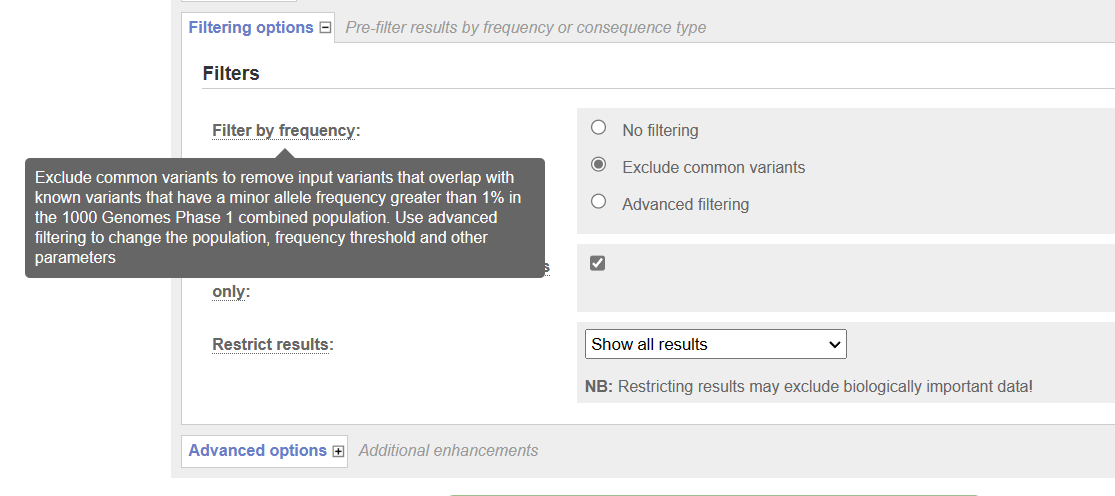

Здесь была плохая фильтрация, из-за чего выпало очень много генов

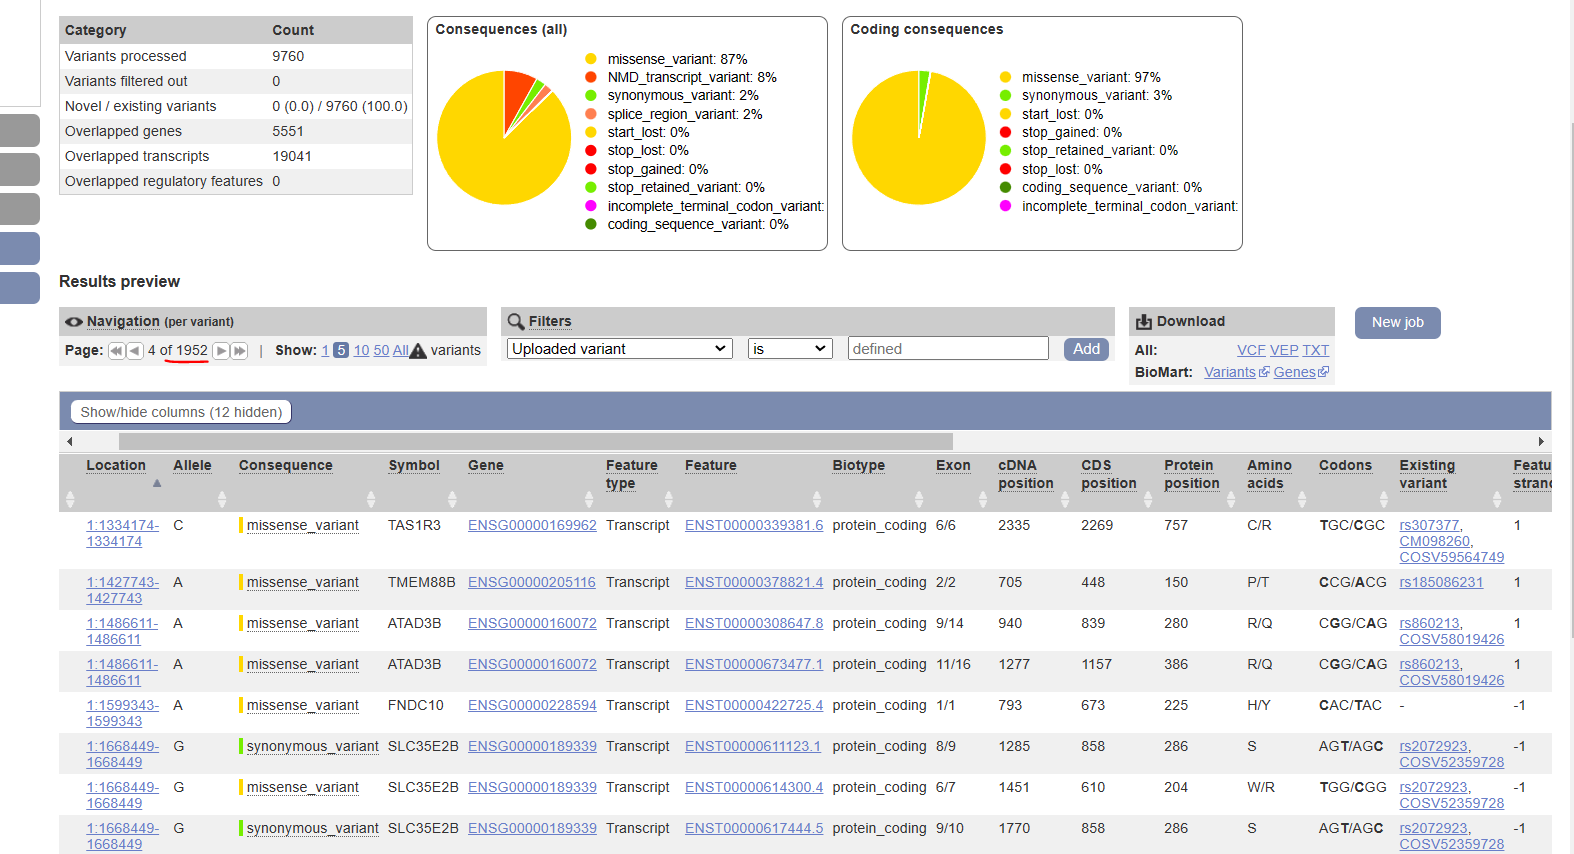

Ссылка на результаты анализа

https://www.ensembl.org/Multi/Tools/VEP/Ticket?tl=8FS9IHDoe4vQBFar

2 анализ

Выберем популяции восточной Азии

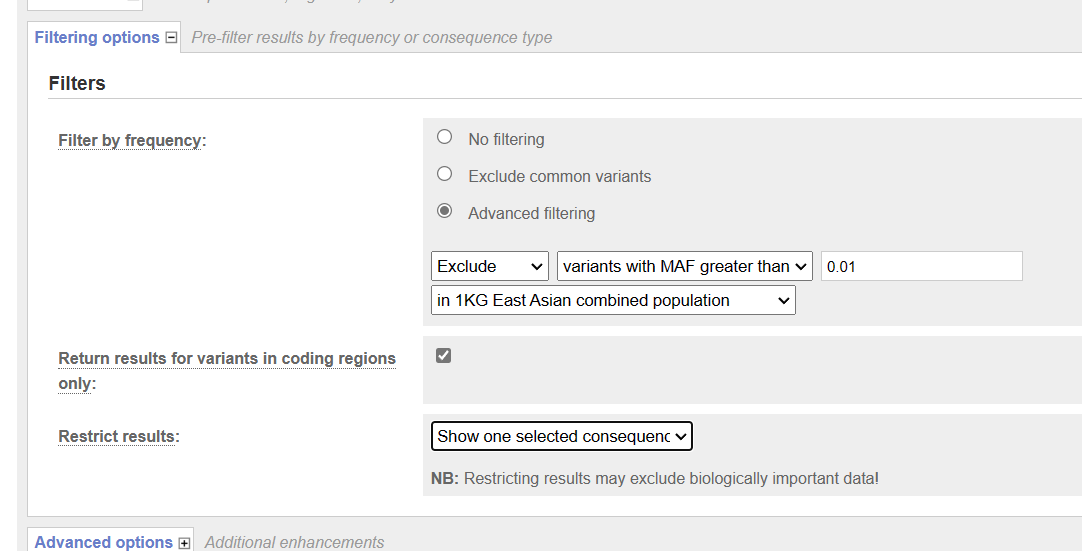

3 анализ

параметр предсказания патогенности по ensembl id (+ то что было во 2 анализе)

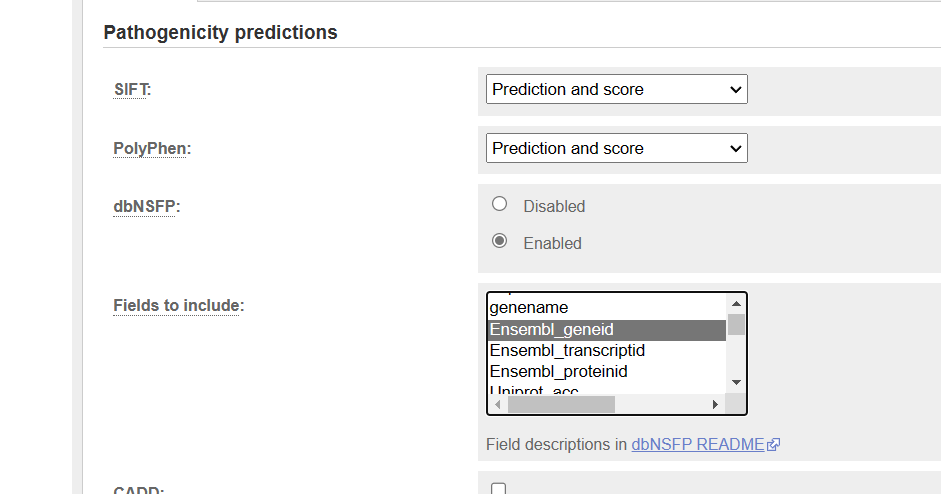

В результате 2 и 3 анализа нашлись идентичные гены

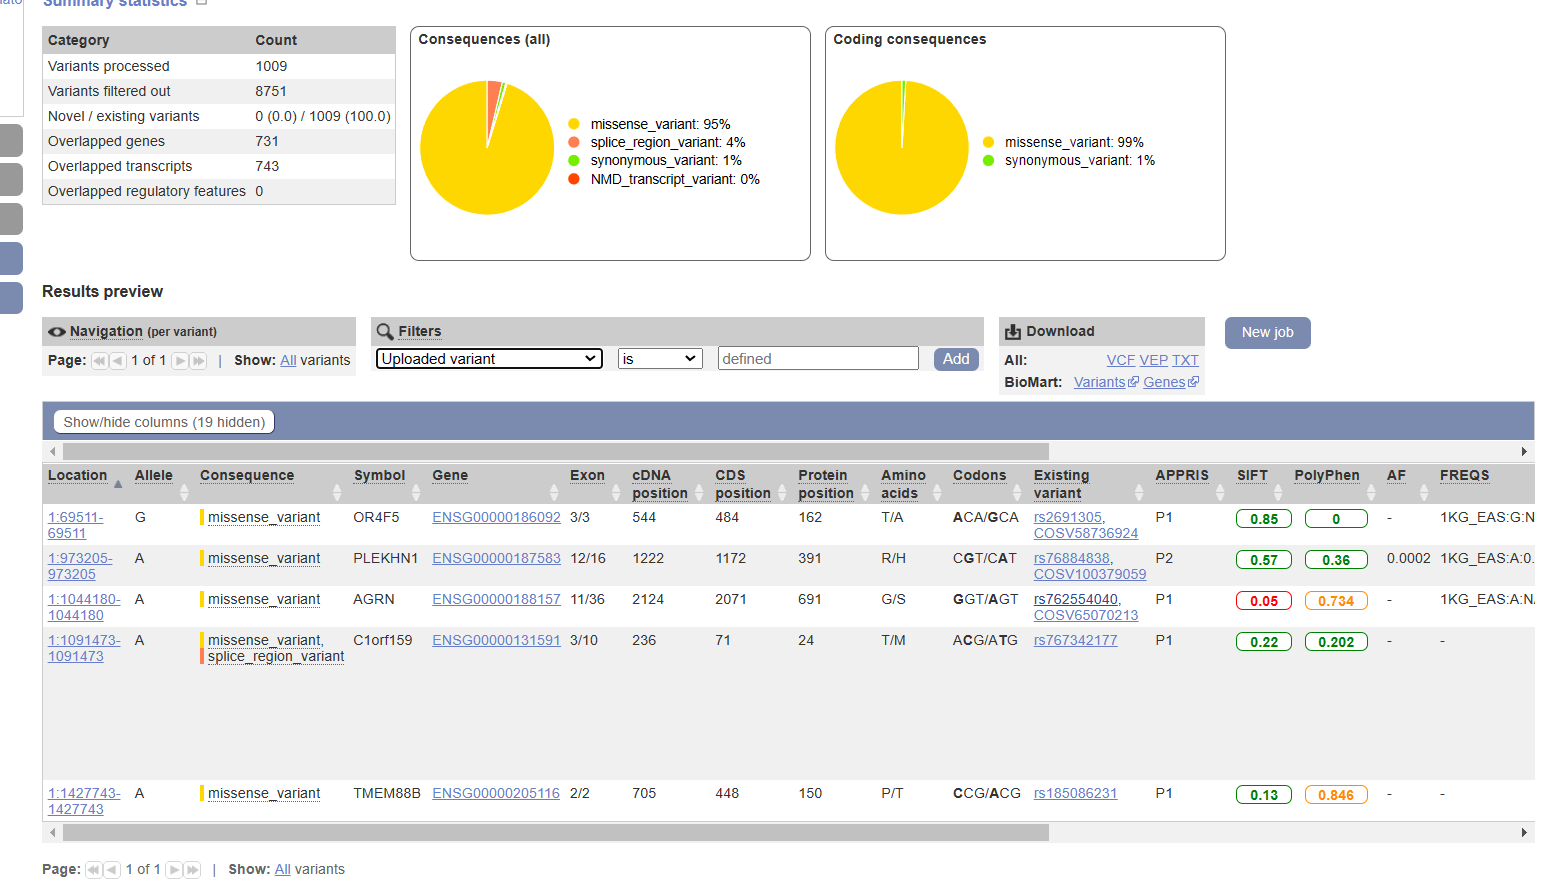

Ссылка на результаты анализа

https://www.ensembl.org/Multi/Tools/VEP/Ticket?tl=QYcqUvubssDpj7Qs

Вредность мутации показывают SIFT и PolyPhen: чем ниже первое и чем выше второе, тем выше "вреднее" мутация, а значит могут вызвать заболевание. Посмотрим, с какими заболеваниями связаны гены AGRN и TMEM88B.

AGRN

Heterozygous agrin (AGRN) gene variant associated with a congenital myasthenic syndrome.

AGRN gene in a patient with catecholaminergic polymorphic ventricular tachycardia suggesting new candidate disease gene.





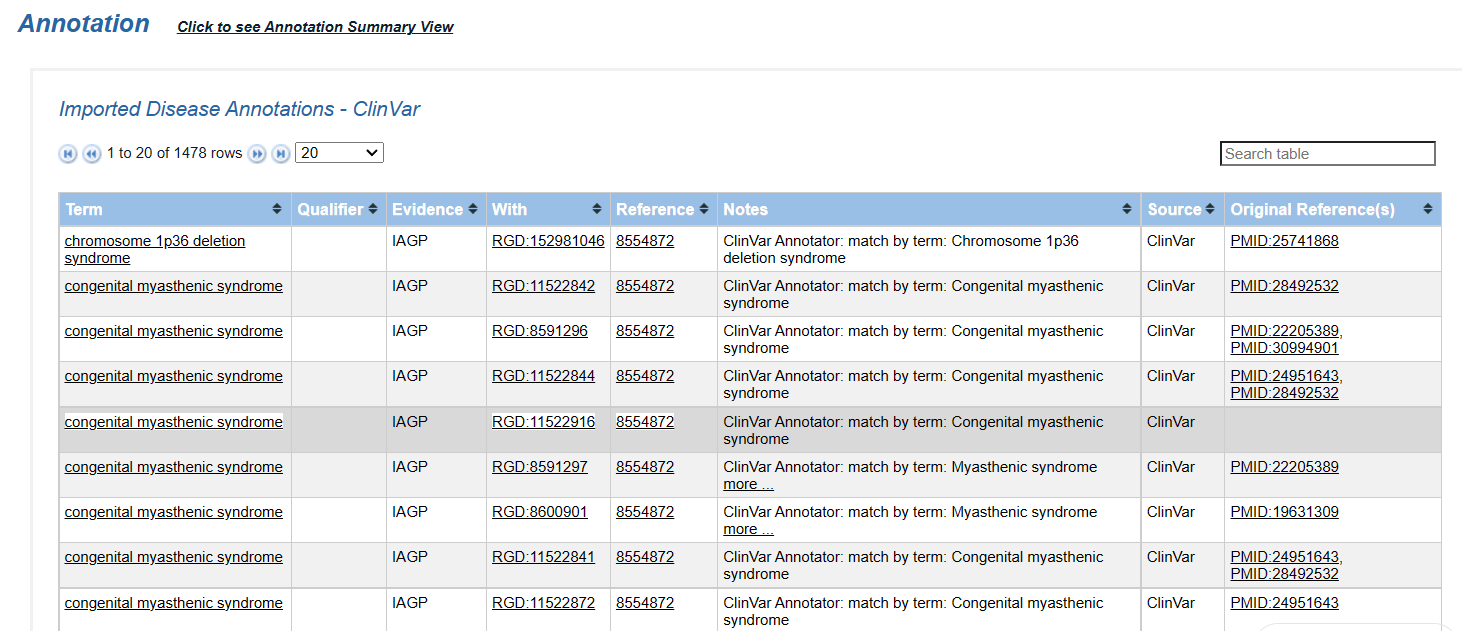

TMEM88B

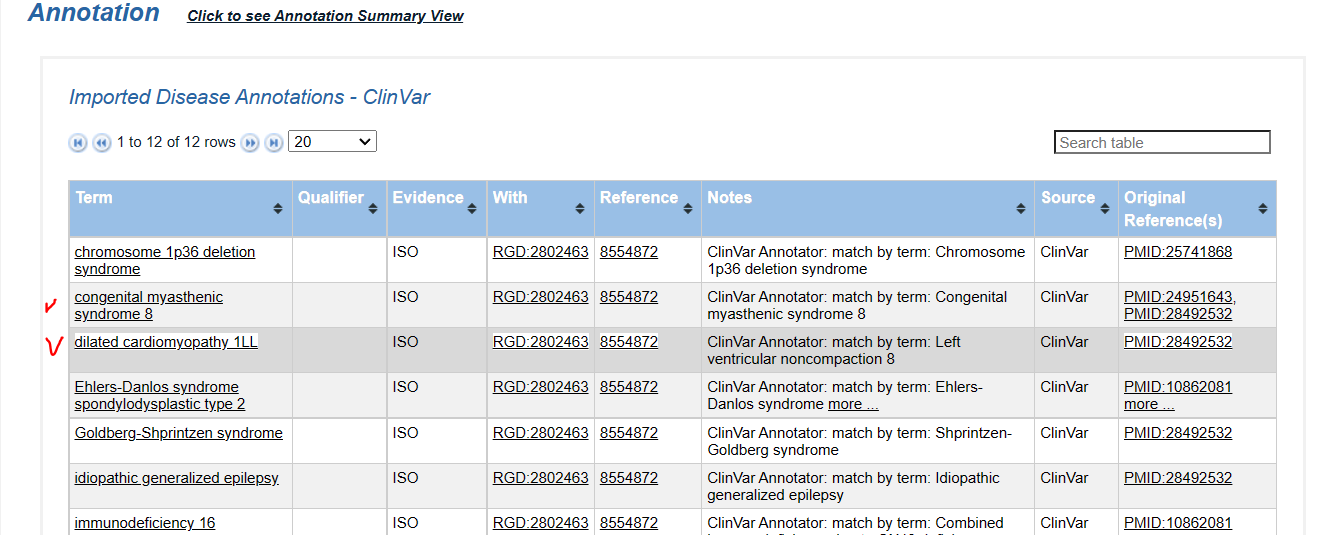

Возможно, данные гены могут быть косвенно связаны с ВПС.

Нашла гены, которые напрямую связаны с врожденным пороком сердца

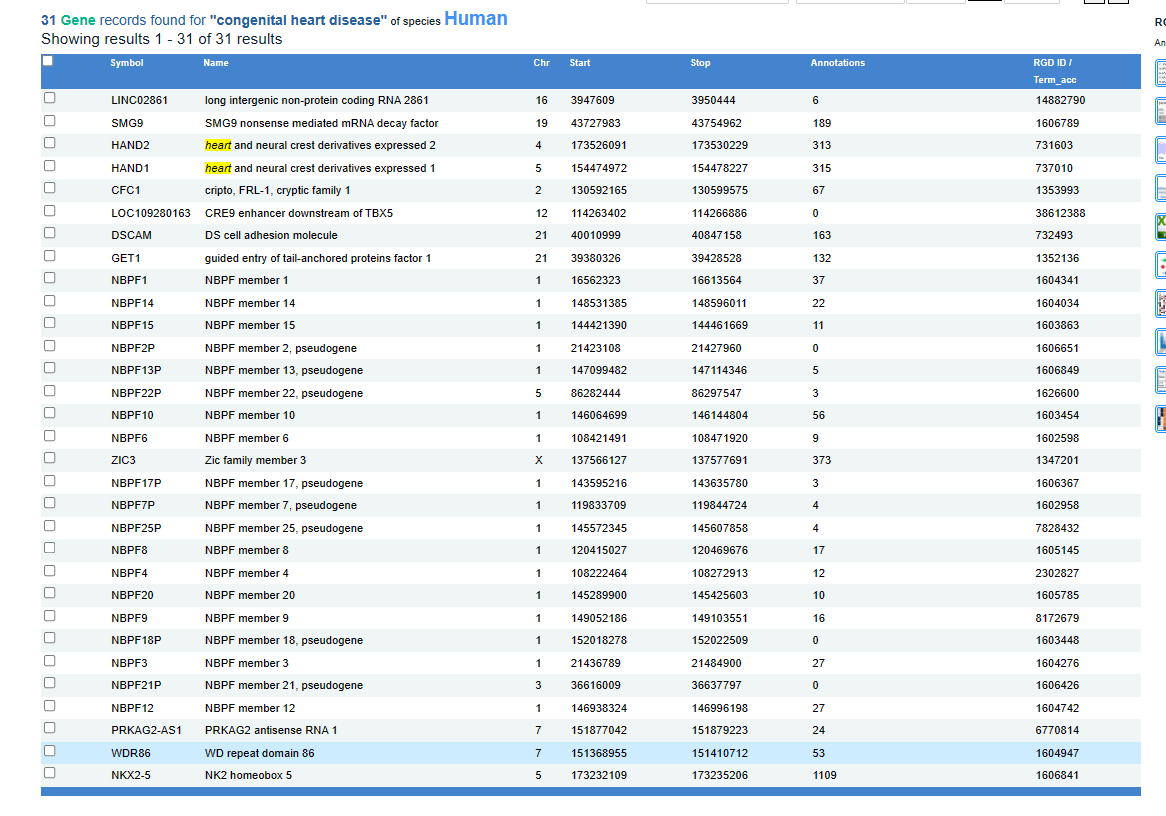

protein-coding из них:

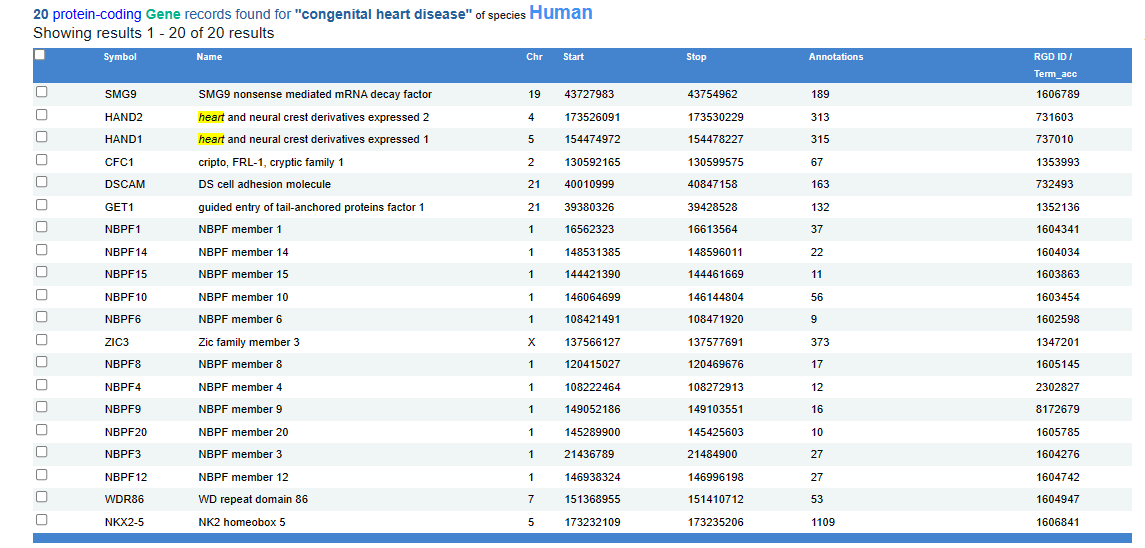

Попробуем пойти от обратного: найдем в наших данных эти гены, загрузим их в ensembl vep и посмотрим на вредность их мутации с помощью SIFT и PolyPhen

In [ ]:
!cat vep.vcf > vep.txt

In [ ]:
!head  vep.txt

chr1	69511	.	A	G	98.14	PASS	AC=2;AF=1.00;AN=2;DP=5;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=45.98;QD=24.54;SOR=1.609;ANN=G|missense_variant|MODERATE|OR4F5|ENSG00000186092|transcript|ENST00000641515.2|protein_coding|3/3|c.484A>G|p.Thr162Ala|544/2618|484/981|162/326||	GT:AD:DP:GQ:PL	1/1:0,4:4:12:112,12,0
chr1	953279	.	T	C	713.06	PASS	AC=2;AF=1.00;AN=2;DP=26;ExcessHet=0.0000;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=60.00;QD=27.43;SOR=0.846;ANN=C|missense_variant|MODERATE|NOC2L|ENSG00000188976|transcript|ENST00000327044.7|protein_coding|9/19|c.898A>G|p.Ile300Val|914/2757|898/2250|300/749||,C|downstream_gene_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000469563.1|retained_intron||n.*4967A>G|||||4967|,C|downstream_gene_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000487214.1|processed_transcript||n.*1147A>G|||||1147|,C|non_coding_transcript_exon_variant|MODIFIER|NOC2L|ENSG00000188976|transcript|ENST00000477976.5|retained_intron|7/17|n.2345A>G||||||	GT:AD:DP:GQ:PL	1/1:0,26

In [ ]:
import pandas as pd
import numpy as np
     
vep = pd.read_csv('vep.txt', sep='\t', names=["CHROM", "POS", "ID", "REF", 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'child'])

vep.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,child
0,chr1,69511,.,A,G,98.14,PASS,AC=2;AF=1.00;AN=2;DP=5;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,4:4:12:112,12,0"
1,chr1,953279,.,T,C,713.06,PASS,AC=2;AF=1.00;AN=2;DP=26;ExcessHet=0.0000;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,26:26:78:727,78,0"
2,chr1,973205,.,G,A,158.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.515;DP=10;E...,GT:AD:DP:GQ:PL,"0/1:3,6:9:87:166,0,87"
3,chr1,976215,.,A,G,396.06,PASS,AC=2;AF=1.00;AN=2;DP=16;ExcessHet=0.0000;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,15:15:45:410,45,0"
4,chr1,978953,.,C,G,193.97,PASS,AC=2;AF=1.00;AN=2;DP=6;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,6:6:18:208,18,0"


Вытащим гены в отдельный столбец

In [ ]:
vep['Genes'] = vep['INFO'].apply(lambda s: s.split("|")[3])
vep.Genes.head()

0      OR4F5
1      NOC2L
2    PLEKHN1
3      PERM1
4      PERM1
Name: Genes, dtype: object

Создадим список генов protein coding, связанных с врожденным пороком сердца

In [ ]:
heart_pr = ['SMG9','HAND2','HAND1','CFC1','DSCAM','GET1','NBPF1','NBPF14',
'NBPF15','NBPF10','NBPF6','ZIC3','NBPF8','NBPF4','NBPF9','NBPF20',
'NBPF3','NBPF12','WDR86','NKX2-5']

Вытащим строчки с этими генами

In [ ]:
vep_df_pr = vep[vep.loc[:,"Genes"].isin(heart_pr)]
vep_df_pr

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,child,Genes
128,chr1,16575173,.,T,C,75.84,PASS,AC=2;AF=1.00;AN=2;DP=3;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,3:3:9:89,9,0",NBPF1
161,chr1,21468895,.,A,G,244.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=0.806;DP=16;Ex...,GT:AD:DP:GQ:PL,"0/1:7,9:16:99:252,0,173",NBPF3
4071,chr7,151381649,.,A,G,55.32,PASS,AC=2;AF=1.00;AN=2;DP=2;ExcessHet=0.0000;FS=0.0...,GT:AD:DP:GQ:PL,"1/1:0,2:2:6:67,6,0",WDR86


Нашлось всего 3 гена среди кодирующих последовательностей с несинонимичными заменами.

In [ ]:
del vep_df_pr["Genes"]
vep_df_pr.to_csv('vep_df_pr.tsv', sep = '\t')

Попробуем загрузить это в ensembl vep и посмотрим на предсказание "вредности" этих мутаций

In [ ]:
!cat vep_df_pr.tsv > vep_df.vcf

In [ ]:
!awk 'NR>1' vep_df.vcf  > vep_genes.vcf

In [ ]:
!head vep_genes.vcf

128	chr1	16575173	.	T	C	75.84	PASS	AC=2;AF=1.00;AN=2;DP=3;ExcessHet=0.0000;FS=0.000;MLEAC=1;MLEAF=0.500;MQ=45.49;QD=25.28;SOR=1.179;ANN=C|missense_variant|MODERATE|NBPF1|ENSG00000219481|transcript|ENST00000430580.6|protein_coding|20/29|c.2176A>G|p.Lys726Glu|3064/5932|2176/3420|726/1139||,C|3_prime_UTR_variant|MODIFIER|NBPF1|ENSG00000219481|transcript|ENST00000392963.5|nonsense_mediated_decay|11/19|n.*1044A>G|||||7545|,C|non_coding_transcript_exon_variant|MODIFIER|NBPF1|ENSG00000219481|transcript|ENST00000392963.5|nonsense_mediated_decay|11/19|n.*1044A>G||||||	GT:AD:DP:GQ:PL	1/1:0,3:3:9:89,9,0
161	chr1	21468895	.	A	G	244.64	PASS	AC=1;AF=0.500;AN=2;BaseQRankSum=0.806;DP=16;ExcessHet=0.0000;FS=2.331;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=15.29;ReadPosRankSum=-0.515;SOR=0.223;ANN=G|missense_variant&splice_region_variant|MODERATE|NBPF3|ENSG00000142794|transcript|ENST00000318249.10|protein_coding|3/15|c.341A>G|p.Tyr114Cys|692/3767|341/1902|114/633||,G|missense_variant&splice_region_

Проведем анализ с этими параметрами

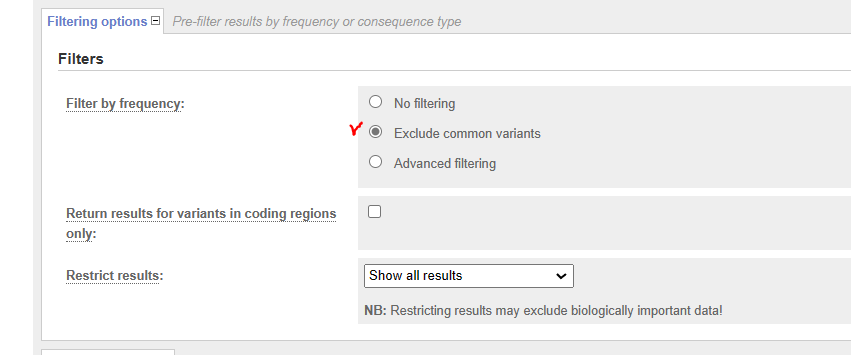

В результате получаем

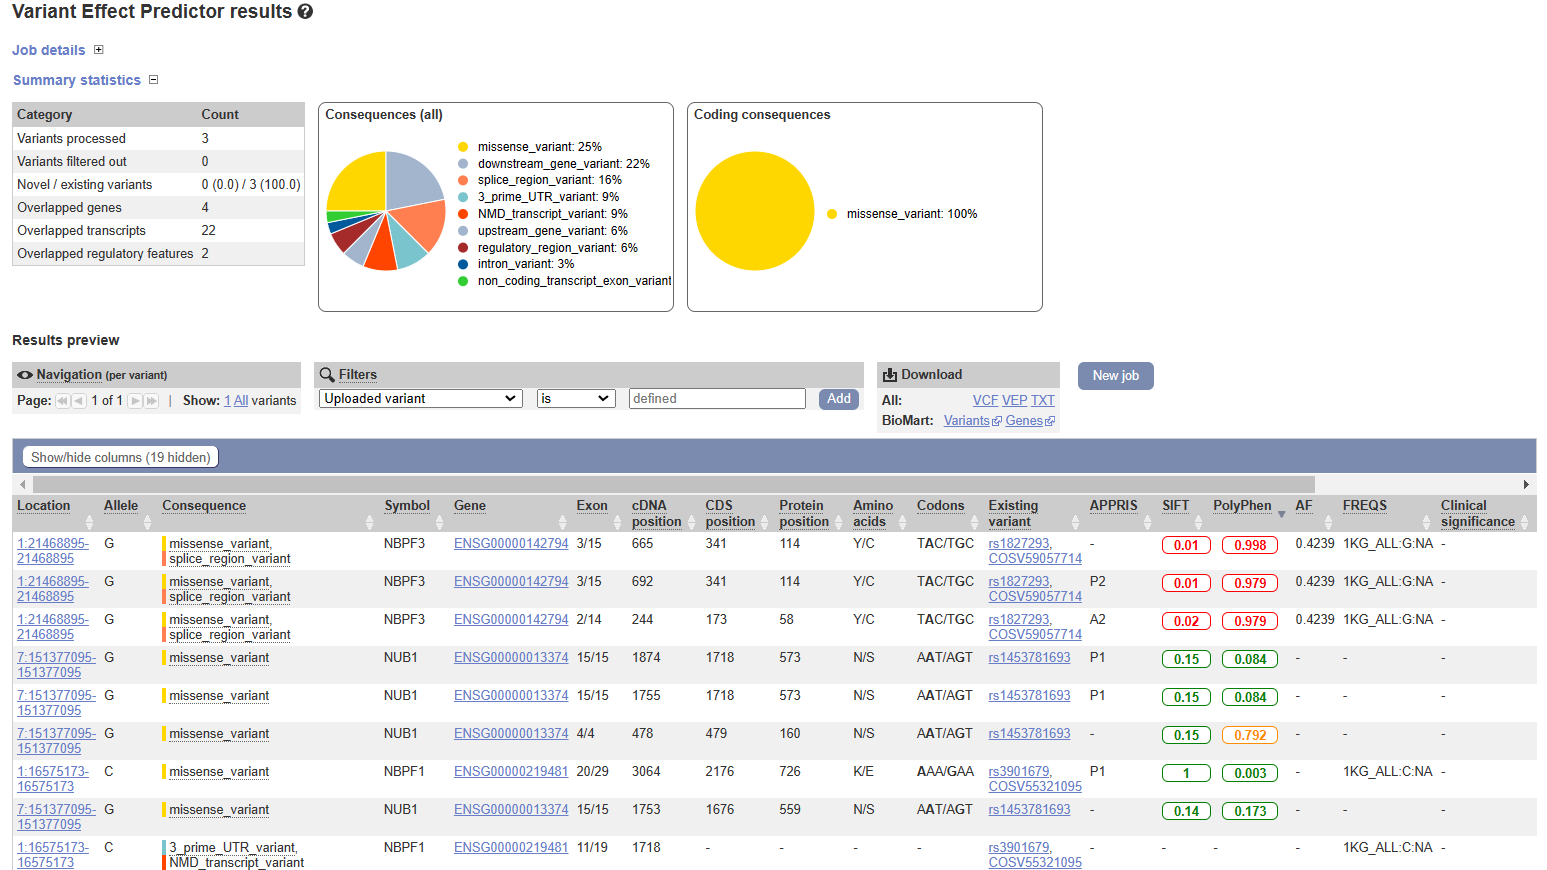

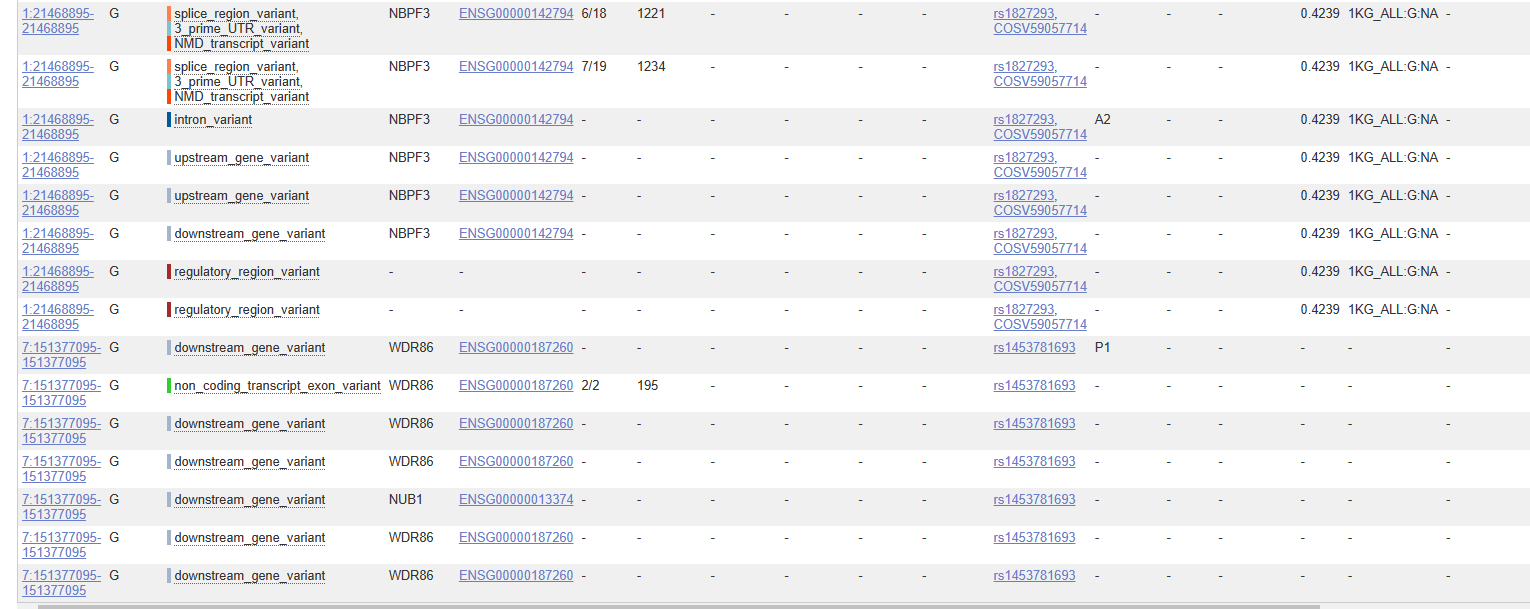

Таким образом, изначально нашлись гены, которые вероятно/могут быть damaging при использовании всех кодирующих вариантов несинонимичных замен. Но сами гены напрямую не связаны с ВПС, но косвенно возможно могут опосредовать его развитие. 

Когда мы выбрали гены, связанные с ВПС из наших данных и загрузили их в ensembl vep, видим, что некоторые из них по SIFT и PolyPhen оказались значимыми. В частности, ген NBPF3 является deleterious по SIFT и probably damaging по PolyPhen. 

Для того, чтобы увидеть гены, связанные с ВПС в файле со всеми кодирующими вариантами несинонимичных замен, необходимо более тщательно и детально подбрирать различные параметры для Variant Effect Predictor (фильтрация и др). 

Ссылка на результаты анализа

https://www.ensembl.org/Multi/Tools/VEP/Ticket?tl=QYcqUvubssDpj7Qs